# Title: Driver Ride Search with Distribution Learning
#### Developed By: Peyman Shahidi
#### Last Updated : June 18, 2020

This code is part of the [Driver Experience or Price Effect Paper](https://www.dropbox.com/scl/fi/u0x5m3bslevs8ap4pmhzi/tapsi_draft_application2022.pdf?rlkey=rect5ux5efkm1wl2hzj898tq1&dl=0).
It models online taxi driver's ride acceptance decision while updating beliefs regarding offers' wage distribution after observing each proposal.


In [ ]:
import numpy as np
import pandas as pd
import pylab as plt
%matplotlib inline
from matplotlib.legend import Legend
import scipy.stats as st
import time
import random
import sys 
from numba import autojit, prange

## Defining Functions

In [2]:
########## μ(t) = A*μ(t-1) + q(t)
########## w(t) = H*μ(t) + e(t)
## x: parameter to be learned -- here mean of normal wage distribution
## P: prior covariance matrix of agent regarding parameter to be learned from previous learned step
## w: measured signal -- received wage offer
## A: transition matrix of parameter to be learned
## H: measurement matrix of parameter to be learned to received signal/wage offer
## Q: covariance matrix of process/state variable
## E: measurement error covariance matrix


def Kalman_Updating(x, P, w, A, H, Q, E):
    
    
    if A.shape != (1,) or H.shape != (1,):
        R = np.dot(A, np.dot(P, A.T)) + Q # prior covariance before seeing measurement in this period knowing the parameter to be learned has itself variance
        e = w - np.dot(H, np.dot(A, x)) # difference between measurement signal and prior belief
        K = np.dot( np.dot(R, H.transpose()), np.linalg.inv(E + np.dot(H, np.dot(R, H.transpose()))) ) # Kalman Gain
    
        updated_x = np.dot(A, x) + np.dot(K, e)
        updated_P = R - np.dot(K, np.dot(H, R))
        
    else:
        R = A **2 * P + Q
        e = w - H * A * x # difference between measurement signal and prior belief
        K = R * H / (E + H **2 * R) # Kalman Gain
    
        updated_x = A * x + K * e
        updated_P = R - K * H * R
    
    return (updated_x, updated_P, K)

## Kalman Filter and Learning:

In [85]:
# Number of iterations in Kalman Filter
n_iter = 500

# random draws from the real wage distribution
real_mu, real_sigma = 1.4, 0.2
real_w = np.array(np.random.normal(real_mu, real_sigma, n_iter)) # measurement inputs

In [86]:
# Initialization
A = np.array([1]) # transition matrix
H = np.array([1]) # measurement matrix
Q = np.array([real_sigma**2]) # process noise covariance matrix

mean = np.array([2]) # initial assumption for mu / prior
P = np.array([real_sigma**2]) # process covariance matrix / equal to the real state covariance

#E = np.array([10]) # measurement error variance
n_errors = 500
E = np.array(np.linspace(0.01, 5000, n_errors))

In [87]:
mean_predicted = pd.DataFrame()
P_predicted = pd.DataFrame()

# Applying the Kalman Filter
for position, e in enumerate(E):
    mu_hat = [mean]
    P_hat = [P]
    mu_aux = mean
    P_aux = P
    
    for period in np.arange(0, n_iter):
        [mu_aux, P_aux] = list(Kalman_Updating(mu_aux, P_aux, real_w[period], A, H, Q, e))[:2]
        mu_hat.append(mu_aux)
        P_hat.append(P_aux)
        
    mean_predicted.insert(position, f"E={int(np.round(e))}", mu_hat[-n_iter:])
    P_predicted.insert(position, f"E={int(np.round(e))}", P_hat[-n_iter:])
    
mean_predicted = mean_predicted.astype(float)
P_predicted = P_predicted.astype(float)

Text(0.5, 1.0, 'Moving (25 window) std of mean prediction while Q=0.04, W~N(1.4,0.04)')

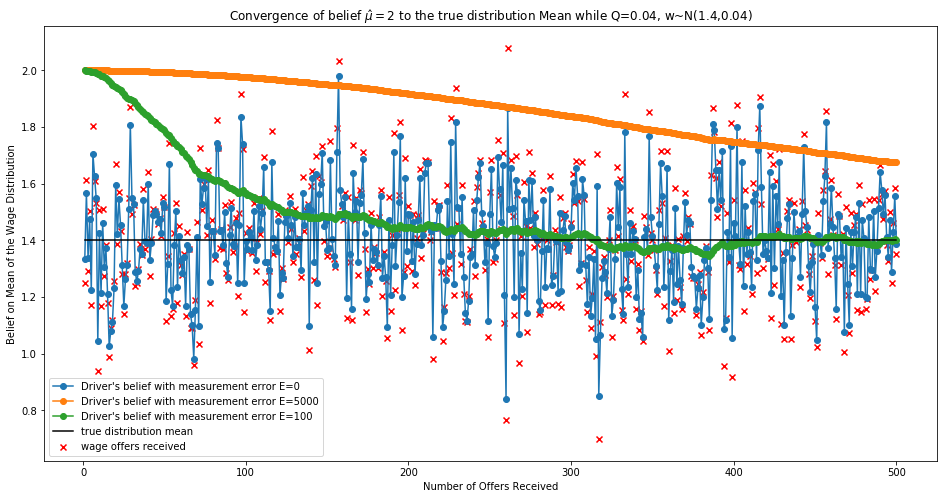

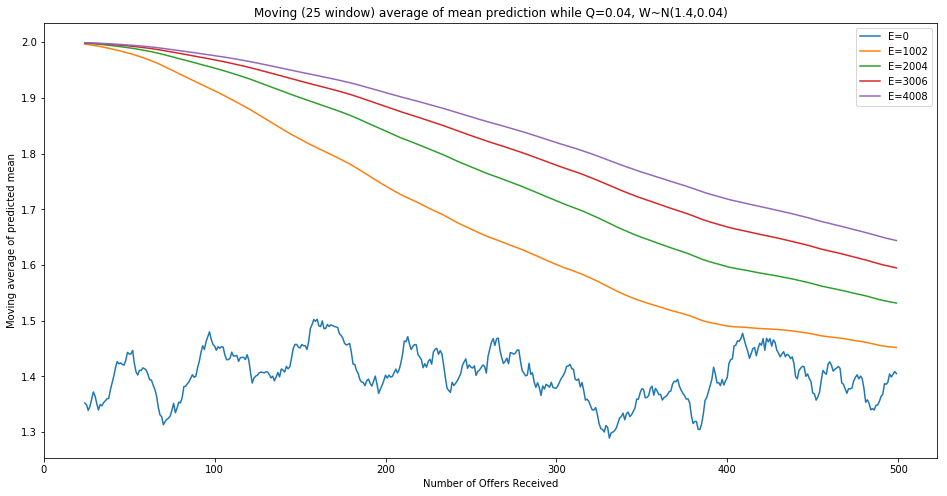

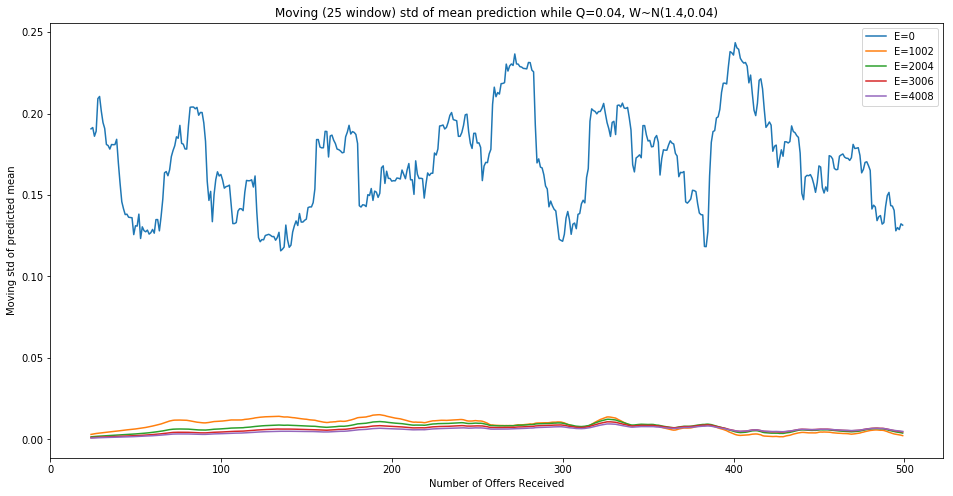

In [99]:
# plotting
number_of_offers_recieved = list()
real_mean = list()
for n in range(n_iter):
    number_of_offers_recieved.append(n+1)
    real_mean.append(real_mu)

fig , ax = plt.subplots(figsize=(16, 8))
plt.scatter(number_of_offers_recieved, real_w, marker='x', color='r', label='wage offers received')
plt.plot(number_of_offers_recieved, mean_predicted.iloc[:,0], \
              linestyle='-', marker='o', label = f'Driver\'s belief with measurement error E={int(E[0])}')
plt.plot(number_of_offers_recieved, mean_predicted.iloc[:,-1], \
              linestyle='-', marker='o', label = f'Driver\'s belief with measurement error E={int(E[-1])}')
plt.plot(number_of_offers_recieved, mean_predicted.iloc[:,10], \
              linestyle='-', marker='o', label = f'Driver\'s belief with measurement error E={int(E[10])}')
plt.plot(number_of_offers_recieved, real_mean, linestyle='-', color='black',label='true distribution mean')
plt.legend(loc='best')
plt.xlabel('Number of Offers Received')
plt.ylabel('Belief on Mean of the Wage Distribution')
plt.title(f"Convergence of belief $μ\u0302 = 2$ to the true distribution Mean while Q={Q[0]:.2f}, w~N({real_mu:.1f},{real_sigma**2:.2f})")
plt.savefig('belief_convergence.jpg', dpi=250, bbox_inches='tight')



## moving window mean and std for different measurement errors

window_length = 25
E_max = int(np.max(E))
number_of_plots = int(len(E) / 5)

plt.figure(figsize=(16, 8))
plt.plot(mean_predicted.iloc[:,list(range(0,len(E),number_of_plots))].rolling(window=window_length).mean())
plt.legend(mean_predicted.columns[list(range(0,len(E),number_of_plots))], loc='best')
plt.xlabel('Number of Offers Received')
plt.ylabel('Moving average of predicted mean')
plt.title(f"Moving ({window_length} window) average of mean prediction while Q={Q[0]:.2f}, W~N({real_mu:.1f},{real_sigma**2:.2f})")
#plt.savefig('L_moving_mean.jpg', dpi=250, bbox_inches='tight')



plt.figure(figsize=(16, 8))
plt.plot(mean_predicted.iloc[:,list(range(0,len(E),number_of_plots))].rolling(window=window_length).std())
plt.legend(mean_predicted.columns[list(range(0,len(E),number_of_plots))], loc='best')
plt.xlabel('Number of Offers Received')
plt.ylabel('Moving std of predicted mean')
plt.title(f"Moving ({window_length} window) std of mean prediction while Q={Q[0]:.2f}, W~N({real_mu:.1f},{real_sigma**2:.2f})")
#plt.savefig('L_moving_std.jpg', dpi=250, bbox_inches='tight')

Text(0.5, 1.0, 'Convergence of belief to the true distribution Mean while Q=0.04, W~N(1.4,0.04)')

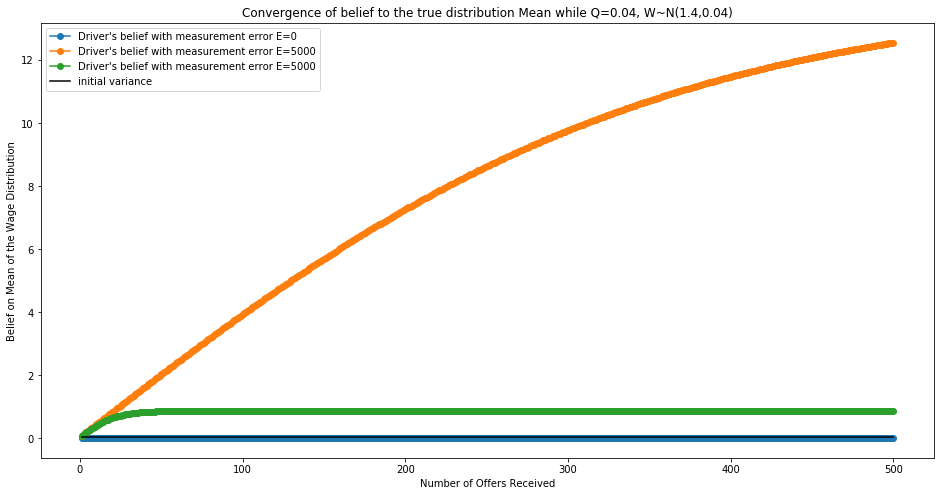

In [92]:
# plotting
number_of_offers_recieved = list()
real_P = list()
for n in range(n_iter):
    number_of_offers_recieved.append(n+1)
    real_P.append(P)

fig , ax = plt.subplots(figsize=(16, 8))
plt.plot(number_of_offers_recieved, P_predicted.iloc[:,0], \
              linestyle='-', marker='o', label = f'Driver\'s belief with measurement error E={int(E[0])}')
plt.plot(number_of_offers_recieved, P_predicted.iloc[:,-1], \
              linestyle='-', marker='o', label = f'Driver\'s belief with measurement error E={int(E[-1])}')
plt.plot(number_of_offers_recieved, P_predicted.iloc[:,2], \
              linestyle='-', marker='o', label = f'Driver\'s belief with measurement error E={int(E[-1])}')
plt.plot(number_of_offers_recieved, real_P, linestyle='-', color='black',label='initial variance')
plt.legend(loc='best')
plt.xlabel('Number of Offers Received')
plt.ylabel('Belief on Mean of the Wage Distribution')
plt.title(f"Convergence of belief to the true distribution Mean while Q={Q[0]:.2f}, W~N({real_mu:.1f},{real_sigma**2:.2f})")
#plt.savefig('L_Convergence.jpg', dpi=250, bbox_inches='tight')

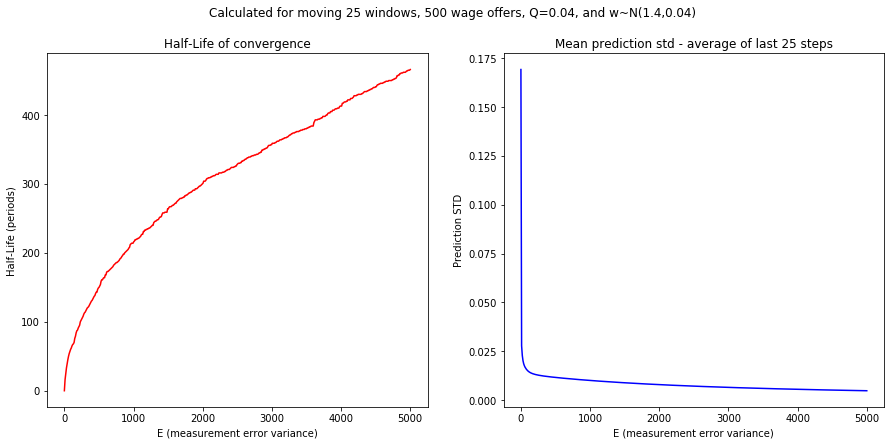

In [95]:
## Convergence and Half-Life

half_life = list()
half = real_mu + (mean[0] - real_mu)/2


# std after converging
mean_prediction_std = mean_predicted[:-100].rolling(window=window_length).std().mean()


# plotting
for counter, e in enumerate(E):
    half_life.append(mean_predicted[mean_predicted.iloc[:,counter] < half].index[0])
half_life

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(15, 6.5))
fig.suptitle(f'Calculated for moving {window_length} windows, {n_iter} wage offers, Q={Q[0]:.2f}, and w~N({real_mu:.1f},{real_sigma**2:.2f})')

ax1.plot(E, half_life, color='r', label='Half-Life')
ax1.set_xlabel('E (measurement error variance)')
ax1.set_ylabel('Half-Life (periods)')
ax1.set_title(f"Half-Life of convergence")

ax2.plot(E, mean_prediction_std, color='b', label='Prediction STD')
ax2.set_xlabel('E (measurement error variance)')
ax2.set_ylabel('Prediction STD')
ax2.set_title(f"Mean prediction std - average of last {window_length} steps")
#plt.savefig('half_life', dpi=250, bbox_inches='tight')

## Search Theory

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  app.launch_new_instance()


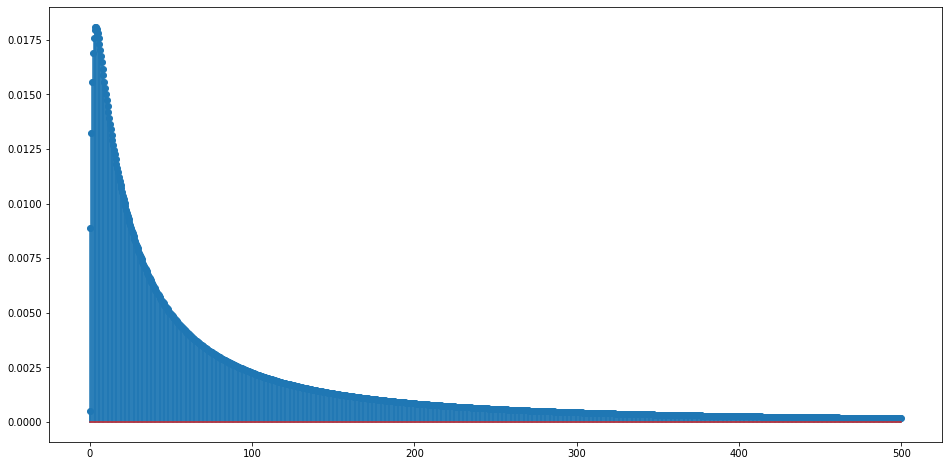

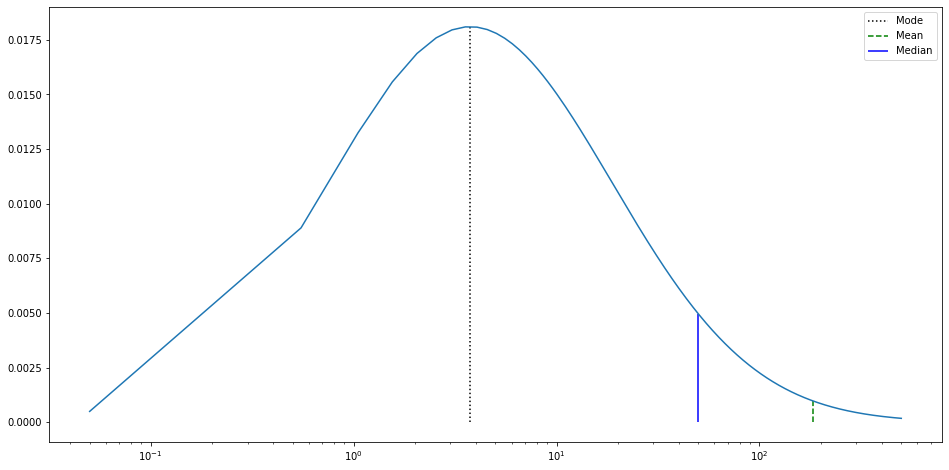

In [9]:
# lognormal dist
M = float(50) # Geometric mean == median
s = float(5) # Geometric standard deviation
mu = np.log(M) # Mean of log(X)
sigma = np.log(s) # Standard deviation of log(X)
shape = sigma # Scipy's shape parameter
scale = np.exp(mu) # Scipy's scale parameter
median = np.exp(mu)
mode = np.exp(mu - sigma**2) # Note that mode depends on both M and s
mean = np.exp(mu + (sigma**2/2)) # Note that mean depends on both M and s

wage = np.linspace(0.05, 500, 1000)
pdf = st.lognorm.pdf(wage, shape, loc=0, scale=scale) # probability distribution
#pdf = pdf / np.sum(pdf)
plt.figure(figsize=(16, 8))
plt.stem(wage , pdf)
plt.figure(figsize=(16, 8))
plt.semilogx(wage, pdf)
plt.vlines(mode, 0, pdf.max(), linestyle=':', label='Mode')
plt.vlines(mean, 0, st.lognorm.pdf(mean, shape, loc=0, scale=scale), linestyle='--', color='green', label='Mean')
plt.vlines(median, 0, st.lognorm.pdf(median, shape, loc=0, scale=scale), color='blue', label='Median')
plt.legend(loc='best')
#st.lognorm.stats(s=2, loc=0, scale=np.exp(mu), moments='m')

<StemContainer object of 3 artists>

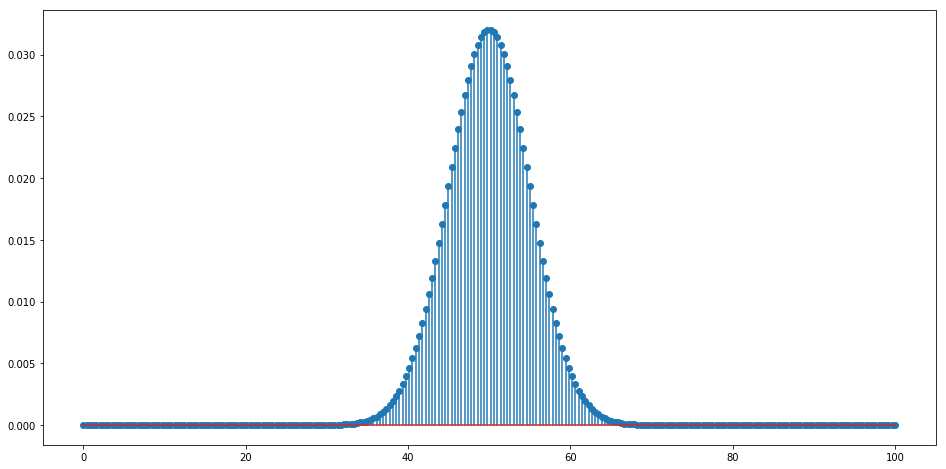

In [3]:
# normal dist

wage = np.linspace(0, 100, 250)
pdf = st.norm.pdf(wage, loc=50, scale=5)
pdf = pdf / np.sum(pdf)
plt.figure(figsize=(16, 8))
plt.stem(wage , pdf)
#st.lognorm.stats(s=2, loc=0, scale=np.exp(mu), moments='m')

# Ride Search With Learning

In [26]:
def offer_value(delta, mu_origin, mu_dest, mu, avg_trip_dur, wage):
    
    # uniform expectation weight for distibution of locations of next offer
    exp_w = 1 / len(mu)
    
    PDF = st.norm.pdf(wage, loc=mu_origin, scale=real_sigma)
    PDF = PDF / np.sum(PDF)
    
    J = np.empty_like(wage)
    
    if delta == DELTA[-1]:
        J = np.ones(len(wage)) * c / (1-delta)
            
    else:
        EEJW, EEJU = 0, 0
        for mu_y in mu:
            # Employment/Acceptance Value
            EJW = offer_value(DELTA[min(list(DELTA).index(delta)+avg_trip_dur, len(DELTA)-1)], mu_dest, mu_y, mu, avg_trip_dur, wage)
            EEJW = EEJW + exp_w * EJW
            
            # Unemployment/Rejection Value
            EJU = offer_value(DELTA[min(list(DELTA).index(delta)+1, len(DELTA)-1)], mu_origin, mu_y, mu, avg_trip_dur, wage)
            EEJU = EEJU + exp_w * EJU
            
        for counter, w in enumerate(wage):
            W = d * w  + EEJW
            U = c + EEJU
            J[counter] = max( (1-delta) * W, delta * U )
    
    return np.sum(J * PDF)

In [27]:
def reservation_wage(delta, mu_origin, mu_dest, mu, trip_dur, avg_trip_dur, wage):
    
    # uniform expectation weight for distibution of locations of next offer
    exp_w = 1 / len(mu)
    
    EEJU, EEJW = 0, 0
    for mu_y in mu:
        # Unemployment/Rejection Value
        EJU = offer_value(delta, mu_origin, mu_y, mu, avg_trip_dur, wage)
        EEJU = EEJU + exp_w * EJU
        
        # Employment/Acceptance Value
        EJW = offer_value(DELTA[min(list(DELTA).index(delta)+trip_dur, len(DELTA)-1)], mu_dest, mu_y, mu, avg_trip_dur, wage)
        EEJW = EEJW + exp_w * EJW
        
    return 1/d * (c + EEJU - EEJW)

### Shift Learning Version of Model

In [28]:
max_ride_offers = 100

# comes from hour/income targeting
max_shift_rides = 10

# unemployment cost
c = -0.5/1000

# trip duration
d = 3

# trip duration characteristics
d_min = 1
d_max = 5
d_avg = 3

# distribution of wage offers
real_mu = 1.4
real_sigma = 0.2
PDF = st.norm.pdf(wage, loc=real_mu, scale=real_sigma)
PDF = PDF / np.sum(PDF) 

In [29]:
#random offers in area 1 and 2

DELTA = np.linspace(0, 1-0.0001, max_shift_rides)


real_w_1 = np.array(np.random.normal(real_mu, real_sigma, max_ride_offers))
real_w_2 = np.array(np.random.normal(real_mu, real_sigma, max_ride_offers))
real_w = (real_w_1, real_w_1, real_w_1, real_w_1)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(22, 11))

ax1.scatter(np.linspace(1,len(real_w[0]), len(real_w[0])), real_w[0], marker='x', color='k', label='trip wage')
ax2.scatter(np.linspace(1,len(real_w[1]), len(real_w[1])), real_w[1], marker='x', color='k', label='trip wage')

In [35]:
# Kalman Filter Initialization
A = np.array([1]) # transition matrix
H = np.array([1]) # measurement matrix
Q = np.array([10]) # process noise covariance matrix
E = np.array([100]) # measurement noise


# initializing areas' prior beliefs
areas = [1, 2, 3]

mu_1 = 2
P_1 = 10 * real_sigma ** 2
mu_2 = 1.4
P_2 = 10 * real_sigma ** 2
mu_3 = 0.8
P_3 = 10 * real_sigma ** 2
mu_4 = 1.4
P_4 = 10 * real_sigma ** 2

mu = (mu_1,mu_2, mu_3)
P = ([P_1], [P_2], [P_3]) # process covariance matrix / equal to the real state covariance

mu_hat = ([mu_1], [mu_2], [mu_3])
P_hat = ([P_1], [P_2], [P_3])






######## running the shift learning version model
# updating and decision making takes place at start of each period

##################### warning: some lines are designed for 2 areas and have not been adjusted for gerenal case ################

## Initialization of variables
R = list()
earnings = [0] ## earnings at the start of period -- always one period longer than other variables
working_area = list()
rejection_dates = list() # dates an offer has been rejected
real_wage = np.array([])

# time of start of working in area
delta = DELTA[0] 

# starting area
starting_area = 3
working_area.append(starting_area)
trip_origin = np.array([starting_area])[0]
mu_aux = mu[starting_area - 1]
P_aux = P[starting_area - 1][:len(areas)] # auxilary P for calculation -- not needed for final results


## simulation
start_time = time.time()
current_location = trip_origin
accepted_offers = 0 # total accepted offers during shift
total_offers = 0 # total received offers during shift
t = 0
while t < max_ride_offers and accepted_offers < max_shift_rides:
    
    iter_time = time.time()
    
    total_offers += 1
        
    #randomly choose destination and duration of trip
    trip_dest = np.random.randint(1,len(areas)+1,1)[0]
    trip_dur = np.random.randint(d_min, d_max + 1,1)[0]
    
    ####################### I have not considered the time dimension.
    mu_origin = mu_hat[current_location - 1][-1] # latest belief in current location
    mu_dest = mu_hat[trip_dest - 1][-1] # latest destination belief
    ####################### I assume each period is a new time of going to the area.
    
    # prior variance
    P_aux = P_hat[current_location - 1][0]
    
    # assign 't'th randomly drawn wage to this trip
    trip_wage = real_w[current_location - 1][t]
    real_wage = np.append(real_wage, [trip_wage])
    ####################### I have assumes no shocks are applied to area wages yet
    
    # updating -current location- belief with received offer
    [mu_aux, P_aux] = list(Kalman_Updating(mu_origin, P_aux, trip_wage, A, H, Q, E))[:2]
    mu_origin = mu_aux[0]
    P_hat[current_location - 1][0] = P_aux[0]
        
    # beliefs of all areas so far (after updating) for calculation of reservation wage -- current belief of all areas
    mu_hat_aux = list(mu_hat)
    mu_hat_aux = [ [i[-1]] for i in list(mu_hat) ]
    mu_hat_aux[current_location - 1] = [mu_origin]
    mu_hat_aux = tuple(mu_hat_aux)
    print(mu_hat_aux)
    
    
    # trip report
    trip_report = f"trip starting in time {t} from origin {current_location} to destination {trip_dest} " \
                    + f"with wage {trip_wage} for {trip_dur} periods:"

    
    # calculating reservation wage with updated belief
    r = reservation_wage(DELTA[accepted_offers], mu_origin, mu_dest, mu_hat_aux, trip_dur, d_avg, wage)
    ######################## needs to be adjusted for random trip durations -- time dimension of delta needs revision
    
    print(t)
    if r > trip_wage:
        acc_indicator = 'Rejected'
        working_area.append(current_location)
        R.append(r)
        earnings.append(earnings[-1]) # total earnings remains unchanged
        mu_hat[current_location - 1].append(mu_origin)
        for location in (loc for loc in areas if loc != current_location):
            mu_hat[location - 1].append(mu_hat[location - 1][-1]) # other locations' belief remains unchanged
        rejection_dates.append(t)
        t += 1
        
    else:
        acc_indicator = 'Accepted'
        if t == 0 :
            earnings[0] = trip_wage
        for counter in range(trip_dur):
            real_wage = np.append(real_wage, np.nan)
            working_area.append(0)
            R.append(r)
            earnings.append(earnings[-1] + trip_wage)
            mu_hat[current_location - 1].append(mu_origin)
            for location in (loc for loc in areas if loc != current_location):
                mu_hat[location - 1].append(mu_hat[location - 1][-1]) # other locations' belief remains unchanged
        real_wage = np.delete(real_wage, len(real_wage)-1, 0) # last NaN is extra
        current_location = trip_dest # set next period's origin to this offer's destination
        accepted_offers += 1
        t += trip_dur 
    
    print(t)
    # report
    print('iteration',total_offers,'run time:', np.round(time.time() - iter_time),'seconds')
    print(trip_report, acc_indicator)
    print('Reservation wage =',r,'\n')


#mu_hat = list(mu_hat)
#mu_hat = np.delete(mu_hat, 0, 1)
#mu_hat = tuple(mu_hat)

# acceptance rate
acc_rate = 100 * accepted_offers / total_offers
print('Shift Acceptance Rate:', acc_rate)

print("\nTotal Run Time: %s minutes" % np.round((time.time() - start_time)/60)) 

([2], [1.4], [0.8655658167928222])
0
4
iteration 1 run time: 63.0 seconds
trip starting in time 0 from origin 3 to destination 1 with wage 1.496006362877651 for 4 periods: Accepted
Reservation wage = 0.7075883244358586 

([1.9320918521180581], [1.4], [0.8655658167928222])
4
5
iteration 2 run time: 22.0 seconds
trip starting in time 4 from origin 1 to destination 2 with wage 1.2791288917147707 for 2 periods: Rejected
Reservation wage = 1.4694442071901677 

([1.8540339228120233], [1.4], [0.8655658167928222])
5
6
iteration 3 run time: 25.0 seconds
trip starting in time 5 from origin 1 to destination 2 with wage 1.4520938390719929 for 1 periods: Accepted
Reservation wage = 0.7744522668681807 

([1.8540339228120233], [1.4400134918246452], [0.8655658167928222])
6
9
iteration 4 run time: 6.0 seconds
trip starting in time 6 from origin 2 to destination 3 with wage 1.8247586055231584 for 3 periods: Accepted
Reservation wage = 1.225167762565573 

([1.8540339228120233], [1.4400134918246452], [0.9

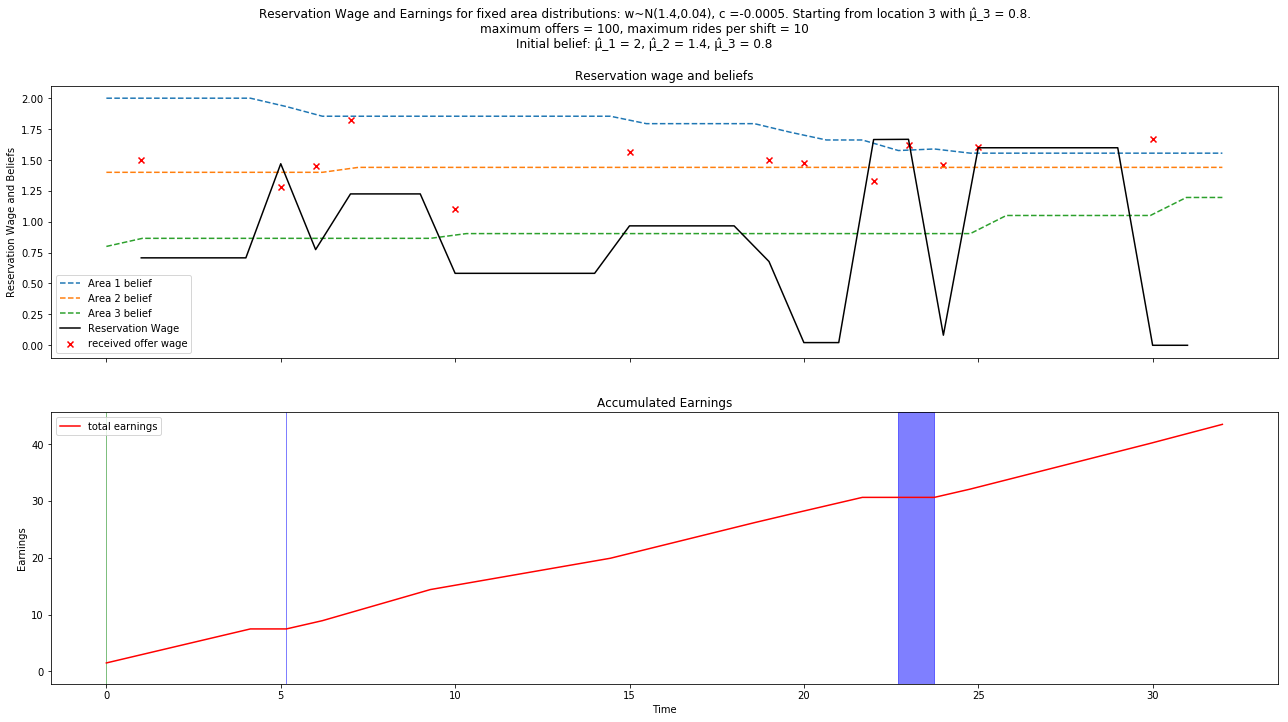

In [36]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(22, 11))

# super title
title = f"Reservation Wage and Earnings for fixed area distributions: w~N({real_mu},{real_sigma**2:.2f}), c ={c}. " +\
        f"Starting from location {starting_area} with μ\u0302_{starting_area} = {mu[starting_area-1]}.\n" +\
        f"maximum offers = {max_ride_offers}, maximum rides per shift = {max_shift_rides}\n" +\
        f"Initial belief: "
for i in range(len(areas)):
    title = title + f"μ\u0302_{i+1} = {mu[i]}, "
    ax1.plot(np.linspace(0,len(mu_hat[i]), len(mu_hat[i])), mu_hat[i], linestyle='--', label=f'Area {i+1} belief')
title = title[:len(title)-2]
fig.suptitle(title)


ax1.plot(np.linspace(1,len(R), len(R)), R, color='k', linestyle='-', label='Reservation Wage')
ax1.scatter(np.linspace(1,len(real_wage), len(real_wage)), real_wage, marker='x', color='r', label='received offer wage')

ax2.plot(np.linspace(0,len(earnings), len(earnings)), earnings, color='r', linestyle='-', label='total earnings')


ax1.legend(loc='best')
ax2.legend(loc='best')
ax2.set_xlabel("Time")


#ax1.text(12.5, 22, f"Real Acceptance Rate={acc_rate:.2f}%", size=13)
#ax1.text(12.2, 20, f"Learned Acceptance Rate={acc_rate:.2f}%", size=13, color='r')

ax1.set_ylabel(r"Reservation Wage and Beliefs")
ax2.set_ylabel(r"Earnings")

ax2.fill_between(np.linspace(0,len(earnings), len(earnings)), 0, 1, 
                 where = np.array(working_area) == 1,
                 color='blue', alpha=0.5, transform=ax2.get_xaxis_transform())
ax2.fill_between(np.linspace(0,len(earnings), len(earnings)), 0, 1, 
                 where = np.array(working_area) == 2,
                 color='orange', alpha=0.5, transform=ax2.get_xaxis_transform())
ax2.fill_between(np.linspace(0,len(earnings), len(earnings)), 0, 1, 
                 where = np.array(working_area) == 3,
                 color='green', alpha=0.5, transform=ax2.get_xaxis_transform())

ax1.set_title(f"Reservation wage and beliefs")
ax2.set_title(f"Accumulated Earnings")

plt.savefig(f'start_from{int(starting_area)}_max_shift={max_shift_rides})', dpi=250, bbox_inches='tight')
plt.show()